In [1]:
import numpy as np
import os

def load_registered_sample(base_directory,registered_directory,start,end):
    corrected_svt = np.load(os.path.join(base_directory, "Corrected_SVT.npy"))
    u = np.load(os.path.join(registered_directory, "Registered_U.npy"))
    delta_f_sample = np.dot(u, corrected_svt[:, start:end])
    return delta_f_sample

def normalize_periodograms(S):
    #try to normalize each signal dividing by its maximum
    max_values = np.max(S, axis=1)
    # divide each row by its maximum value
    S = S / max_values.reshape(-1, 1)
    return S

def compute_distance(i,j,H,W,loc):
    r_i, c_i = np.unravel_index(loc[0][i], (H,W))
    r_j, c_j = np.unravel_index(loc[0][j], (H,W))
    return np.sqrt((r_i-r_j)^2+(c_i-c_j)^2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore 

from skimage.measure import block_reduce

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

(50, 51)

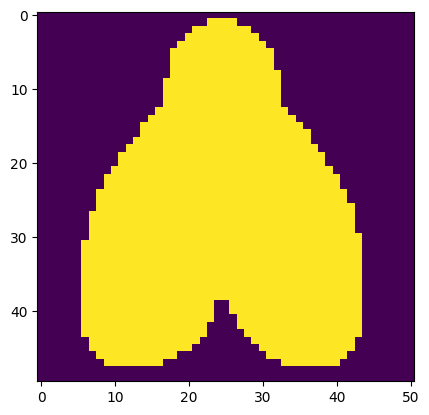

In [35]:
base_directory = r"/home/k21208334/calcium_analyses/data/" + "NXAK22.1A" + "/"

mask_dict = np.load(r"/home/k21208334/calcium_analyses/data/Tight_Mask_Dict.npy", allow_pickle=True)[()]

array_indicies = np.array(mask_dict['indicies'])

image = np.ravel(np.zeros((300,304)))
image[array_indicies]=1
plt.imshow(np.reshape(image,(300,304)))

downsampled_tight_mask = block_reduce(np.reshape(image,(300,304)), block_size=(6,6), func=np.min) 
plt.imshow(downsampled_tight_mask)

final_mask = downsampled_tight_mask>0


 starting:  NXAK22.1A


/tmp/ipykernel_390849/2066397849.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((r_i-r_j)^2+(c_i-c_j)^2)


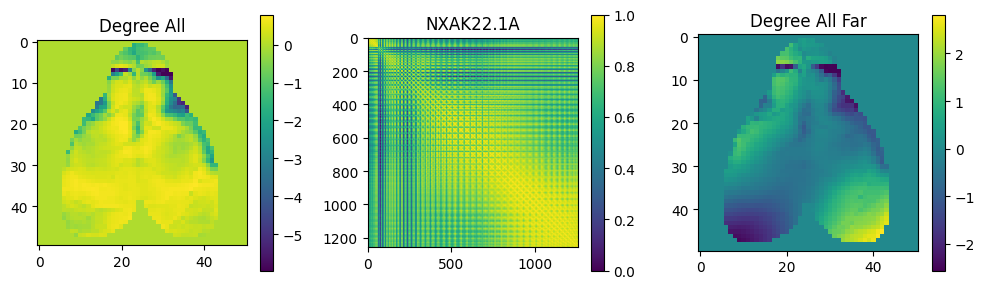


 starting:  NXAK14.1A


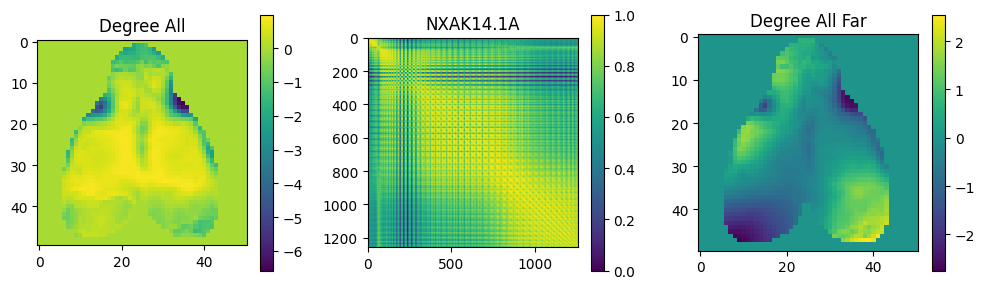


 starting:  NXAK7.1B


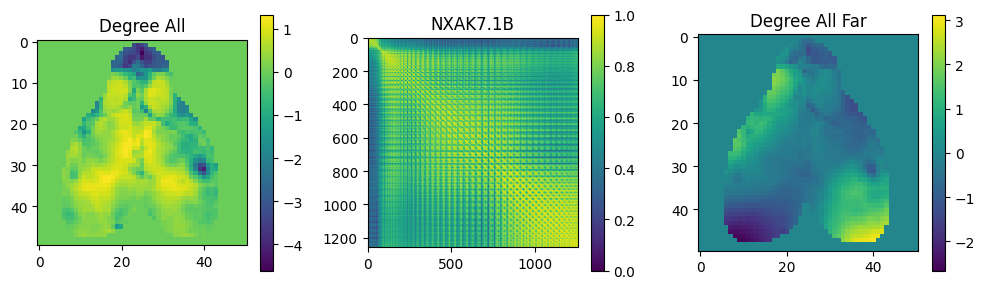


 starting:  NXAK4.1B


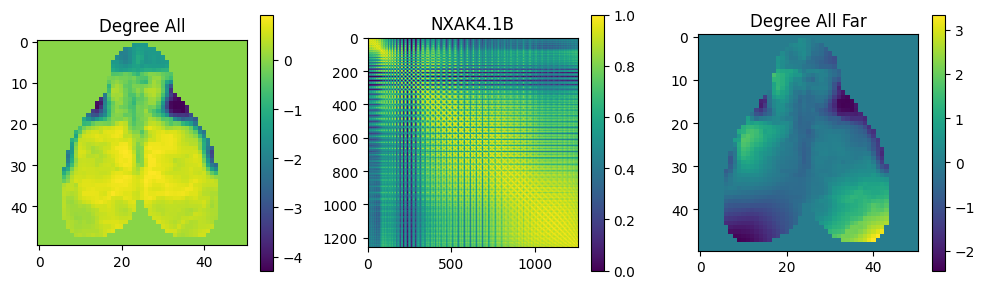


 starting:  NRXN78.1D


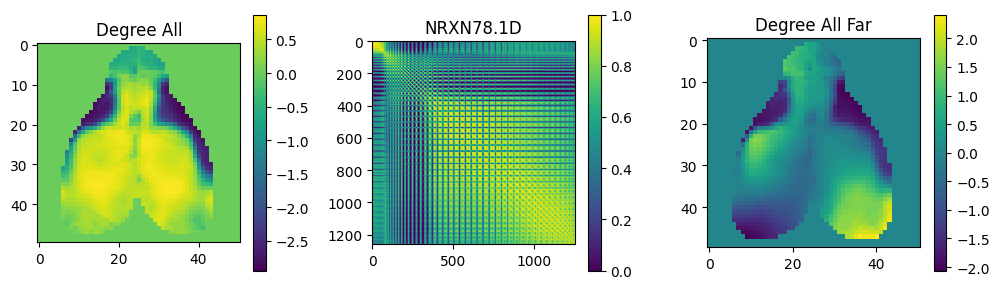


 starting:  NRXN78.1A


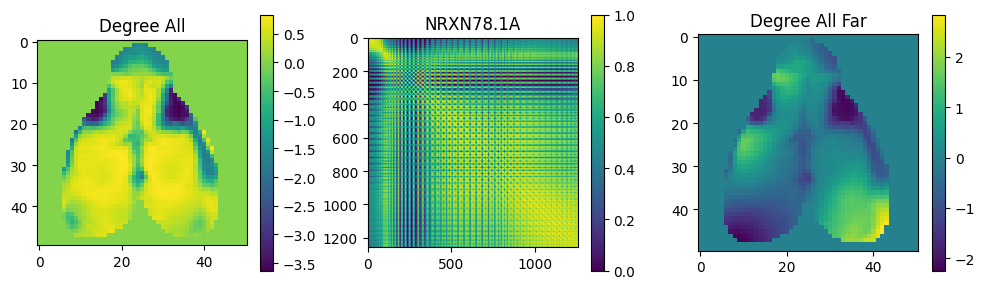


 starting:  NXAK24.1C


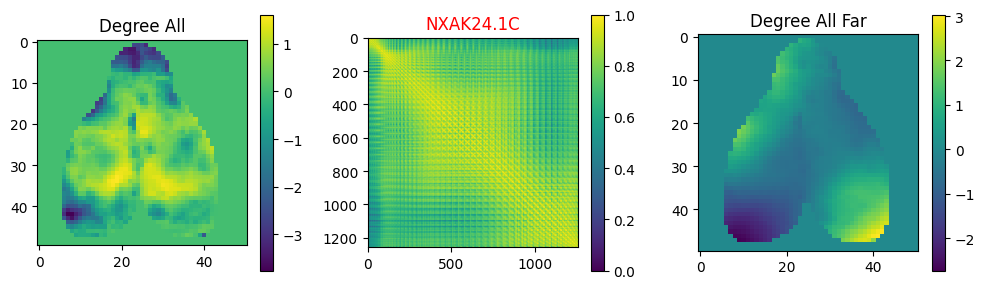


 starting:  NXAK20.1B


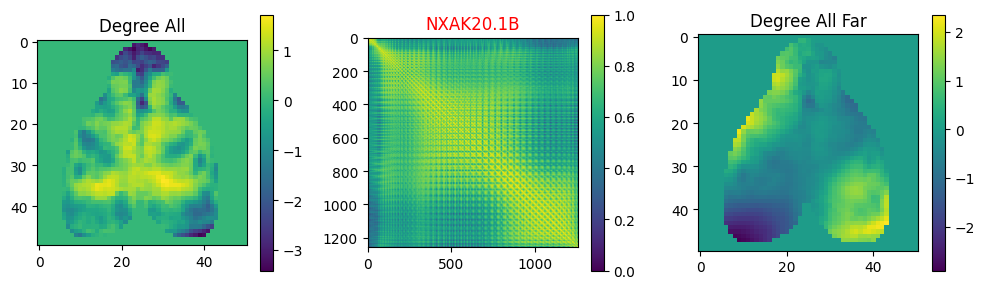


 starting:  NXAK16.1B


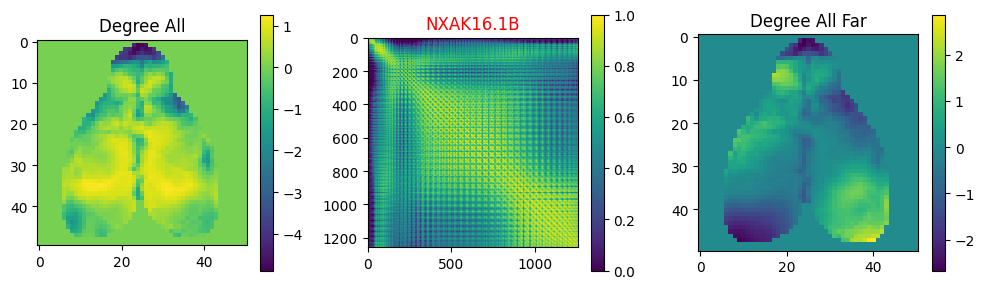


 starting:  NXAK10.1A


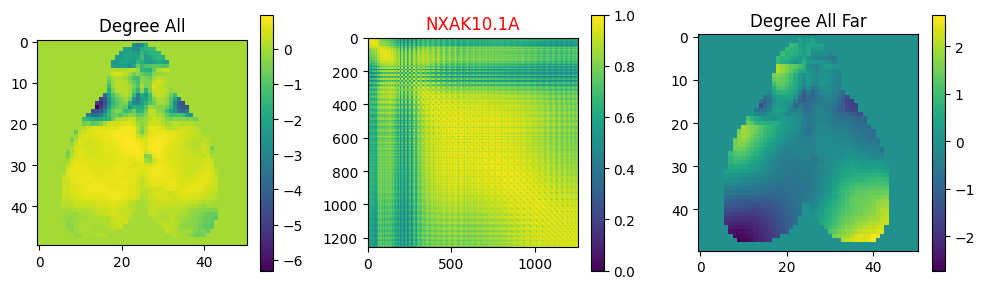


 starting:  NXAK4.1A


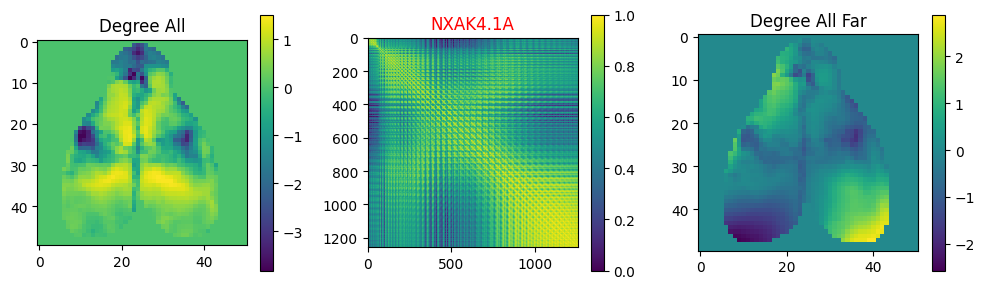


 starting:  NRXN71.2A


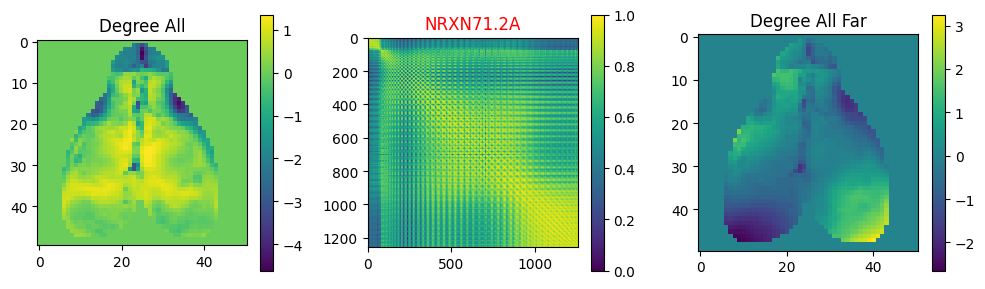

In [42]:
names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]


h=300
w=304
connectivity_thr = 0.2
distance_threshold = 3 #arbitraty!

start = 0
end = 6500


for name in names+names_knock:
    
    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    registered_directory = r"/home/k21208334/calcium_analyses/data/registration_data/" + name + "/"

    print("\n starting: ",name)

    sample = load_registered_sample(base_directory,registered_directory,start,end)
    coarse_sample = block_reduce(sample, block_size=(6,6,1), func=np.mean) 
    #  connectivity: flatten data
    H = np.shape(coarse_sample)[0]
    W = np.shape(coarse_sample)[1]
    all_signals = np.reshape(coarse_sample,(H*W,end))
    # remove zero signals based on mask!
    good_indices = np.ravel(final_mask)
    good_indices_locations = np.where(good_indices)
    signals = all_signals[good_indices,:]
    connectivity = np.corrcoef(signals) 
    thresholded_connectivity = connectivity
    thresholded_connectivity[connectivity<connectivity_thr] = 0
    
    #create "far" connectivity matrix
    connectivity_far = np.zeros(connectivity.shape)
    for i, row in enumerate(connectivity_far):
        for j, element in enumerate(row):
            if compute_distance(i,j,H,W,good_indices_locations)>distance_threshold:
                connectivity_far[i,j] = thresholded_connectivity[i,j]
    
    degree = np.sum(thresholded_connectivity,axis=0) # put threshold to 0.2 and sum positive. Them 
    degree_z = zscore(degree)
    degree_far = np.sum(connectivity_far,axis=0)
    degree_far_z = zscore(degree_far)
    
    degree_all = np.zeros(all_signals.shape[0])
    degree_all[good_indices] = degree_z
    degree_all_far = np.zeros(all_signals.shape[0])
    degree_all_far[good_indices] = degree_far_z
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1, 1.05]})

    im0=ax[0].imshow(np.reshape(degree_all,(H,W)))
    m = plt.cm.ScalarMappable()
    m.set_clim(vmin=degree_all.min(), vmax=degree_all.max())
    fig.colorbar(m,ax=ax[0])
    im1=ax[1].imshow(connectivity)
    m = plt.cm.ScalarMappable()
    m.set_clim(vmin=connectivity.min(), vmax=connectivity.max())
    fig.colorbar(m,ax=ax[1])
    im2=ax[2].imshow(np.reshape(degree_all_far,(H,W)))
    m = plt.cm.ScalarMappable()
    m.set_clim(vmin=degree_all_far.min(), vmax=degree_all_far.max())
    fig.colorbar(m,ax=ax[2])
    
    # set the titles and labels
    ax[0].set_title('Degree All')
    if name in names_knock:
        ax[1].set_title(name,fontdict={'color': 'red'})
    else:
        ax[1].set_title(name)
    ax[2].set_title('Degree All Far')

    plt.tight_layout()
    plt.show()

In [38]:
connectivity.shape
good_indices_locations = np.where(good_indices)


In [39]:
good_indices_locations[0].shape

(1258,)

In [8]:
H*W

2550

In [13]:
good_indices_locations[0].max()


2544

In [21]:
degree.min()

0.9999999999999999